In [93]:
%matplotlib inline

import numpy as np
import rasterio as rio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterstats


In [94]:
# Define the landcover class names in a list
names = ['Broadleaf woodland', 'Coniferous woodland', 'Arable and Horticulture', 'Improved grassland', 
         'Semi-natural grassland', 'Mountain, heath, bog', 'Saltwater', 'Freshwater', 'Coastal', 
         'Built-up areas and gardens', 'Neutral Grassland', 'Calcareous Grassland', 'Acid Grassland', 
         'Heather', 'Heather grassland', 'Fen, Marsh and Swamp', 'Bog', 'Inland Rock', 'Urban', 
         'Suburban', 'Supra-littoral Rock', 'Supra-littoral Sediment', 'Littoral Rock']

values = range(1, 24)  # Get numbers from 1-23, corresponding to the landcover values


In [95]:
# Create a dictionary of landcover value/name pairs
landcover_names = dict(zip(values, names))

In [96]:
# Load the Liverpool landuse raster data
with rio.open('C:/EGM722/egm722/green_space_project/raster/LCM2015_Liverpool.tif') as dataset:
    xmin, ymin, xmax, ymax = dataset.bounds
    crs = dataset.crs
    landcover = dataset.read(1)
    affine_tfm = dataset.transform

In [97]:
# Load the Liverpool wards shapefile
wards = gpd.read_file('C:/EGM722/egm722/green_space_project/data_files/wards.shp').to_crs(crs)


In [98]:
# Define a function to count unique landcover classes
def count_unique(array, names, nodata=0):
    '''
    Count the unique elements of an array.

    :param array: Input array
    :param names: a dict of key/value pairs that map raster values to a name
    :param nodata: nodata value to ignore in the counting

    :returns count_dict: a dictionary of unique values and counts
    '''
    count_dict = dict()  # Create the output dict
    for val in np.unique(array):  # Iterate over the unique values for the raster
        if val == nodata:  # If the value is equal to our nodata value, move on to the next one
            continue
        count_dict[names[val]] = np.count_nonzero(array == val)
    return count_dict  # Return the now-populated output dict


In [99]:
# Check unique values in the Liverpool landuse raster
unique_values = np.unique(landcover)

# Compare unique values with keys in the landcover_names dictionary
missing_values = [val for val in unique_values if val not in landcover_names.keys()]

# Display missing values
if missing_values:
    print("The following values are missing from the landcover_names dictionary:", missing_values)
else:
    print("All unique values in the landcover raster are accounted for in the landcover_names dictionary.")

# Update the landcover_names dictionary to include missing values
for missing_val in missing_values:
    landcover_names[missing_val] = f"Unknown_{missing_val}"

# Recount unique landcover classes in the Liverpool landuse raster
landcover_count = count_unique(landcover, landcover_names)
print(landcover_count)  # Show the updated results


The following values are missing from the landcover_names dictionary: [0]
{'Broadleaf woodland': 17356, 'Coniferous woodland': 561, 'Arable and Horticulture': 18787, 'Improved grassland': 25582, 'Semi-natural grassland': 12272, 'Acid Grassland': 495, 'Heather': 3448, 'Fen, Marsh and Swamp': 2674, 'Bog': 810, 'Inland Rock': 43112, 'Urban': 665, 'Suburban': 75398, 'Supra-littoral Rock': 130499}


In [100]:
# Find missing landcover types and add them to the dictionary
missing_landcover_names = []
for val in unique_values:
    if val not in landcover_names:
        missing_landcover_names.append(val)
# Add missing landcover types to the dictionary
for missing_val in missing_landcover_names:
    # You can provide a default name or prompt the user for input
    default_name = f"Unknown Landcover {missing_val}"
    landcover_names[missing_val] = input(f"Enter name for landcover type {missing_val} (default: {default_name}): ") or default_name


In [101]:
# Count unique landcover classes in the Liverpool landuse raster
landcover_count = count_unique(landcover, landcover_names)
print(landcover_count)  # Show the results


{'Broadleaf woodland': 17356, 'Coniferous woodland': 561, 'Arable and Horticulture': 18787, 'Improved grassland': 25582, 'Semi-natural grassland': 12272, 'Acid Grassland': 495, 'Heather': 3448, 'Fen, Marsh and Swamp': 2674, 'Bog': 810, 'Inland Rock': 43112, 'Urban': 665, 'Suburban': 75398, 'Supra-littoral Rock': 130499}


In [102]:
# error with bounding box so sorting this 
import rasterstats
import rasterio
from shapely.geometry import box

# Define the paths to the Liverpool raster and wards shapefile
raster_path = r"C:\EGM722\egm722\green_space_project\raster\LCM2015_Liverpool.tif"
wards_path = r"C:\EGM722\egm722\green_space_project\data_files\wards.shp"

# Load the wards shapefile
wards = gpd.read_file(wards_path)

# Read the raster file
with rasterio.open(raster_path) as src:
    # Get the affine transformation matrix
    affine_tfm = src.transform
    
    # Read the raster as a numpy array
    landcover = src.read(1)
    
    # Get the nodata value
    nodata = src.nodata

# Check and update the raster bounds
geom_bounds = wards.total_bounds
if any(not np.isfinite(coord) for coord in geom_bounds):
    print("Warning: Invalid bounding box coordinates detected. Attempting to correct...")
    valid_geom = box(*wards.geometry.total_bounds)
    geom_bounds = valid_geom.bounds
    print("Corrected bounding box:", geom_bounds)

# Use rasterstats.zonal_stats() to get zonal statistics for Liverpool wards
try:
    ward_stats = rasterstats.zonal_stats(wards,
                                         landcover,
                                         affine=affine_tfm,
                                         categorical=True,
                                         category_map=landcover_names,
                                         nodata=nodata)
except OverflowError as e:
    print("Error:", e)
    print("OverflowError encountered. Please check the raster bounds and try again.")


In [103]:
# Use rasterstats.zonal_stats() to get zonal statistics for Liverpool wards
ward_stats = rasterstats.zonal_stats(wards,  # The shapefile to use
                                     landcover,  # The raster to use - here, we're using the numpy array loaded using rasterio
                                     affine=affine_tfm,  # The geotransform for the raster
                                     categorical=True,  # Whether the data are categorical
                                     category_map=landcover_names,
                                     nodata=0  # The nodata value for the raster
                                     )

In [104]:
# Create a dictionary of landcover stats by ward
ward_dict = dict(zip(wards['wardname'].str.title(), ward_stats))


In [105]:
# Check keys in landcover_names dictionary
print("Keys in landcover_names dictionary:")
print(landcover_names.keys())

# Check keys in ward_data dictionary for a specific ward
ward_data = ward_dict.get(wards['wardname'].iloc[0].title(), {})
print("\nKeys in ward_data dictionary for the first ward:")
print(ward_data.keys())


Keys in landcover_names dictionary:
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0])

Keys in ward_data dictionary for the first ward:
dict_keys(['Broadleaf woodland', 'Improved grassland', 'Fen, Marsh and Swamp', 'Bog', 'Inland Rock', 'Urban', 'Suburban', 'Supra-littoral Rock'])


In [106]:
#THIS WORKED
# Add landcover stats to the wards table
short_names = ['broadleaf', 'coniferous', 'arable', 'imp_grass', 'nat_grass',
               'mountain', 'saltwater', 'freshwater', 'coastal', 'built_up']
short_dict = dict(zip(landcover_names.values(), short_names))

# Add a default short name for unknown landcover types
short_dict.setdefault('Unknown', 'unknown')

for ind, row in wards.iterrows():
    ward_data = ward_dict.get(row['wardname'].title(), {})  # Use .get() to return an empty dictionary if wardname not found
    for name in ward_data.keys():
        short_name = short_dict.get(name, 'unknown')
        wards.loc[ind, short_name] = ward_data[name]


In [107]:
# Add landcover stats to the wards table
short_names = ['broadleaf', 'coniferous', 'arable', 'imp_grass', 'nat_grass',
               'mountain', 'saltwater', 'freshwater', 'coastal', 'built_up',
               'neutral_grass', 'calcareous_grass', 'acid_grass', 'heather',
               'heather_grass', 'fen_marsh_swamp', 'bog', 'inland_rock', 'urban',
               'suburban', 'supra_littoral_rock', 'supra_littoral_sediment', 'littoral_rock']
short_dict = dict(zip(names, short_names))

# Add a default short name for unknown landcover types
short_dict.setdefault('Unknown', 'unknown')

for ind, row in wards.iterrows():
    ward_data = ward_dict.get(row['wardname'].title(), {})  # Use .get() to return an empty dictionary if wardname not found
    for name in ward_data.keys():
        short_name = short_dict.get(name, 'unknown')
        wards.loc[ind, short_name] = ward_data[name]


In [108]:
# Add landcover stats to the wards table
for ind, row in wards.iterrows():
    ward_data = ward_dict.get(row['wardname'].title(), {})  # Use .get() to return an empty dictionary if wardname not found
    for name in ward_data.keys():
        if name in short_names:  # Check if the landcover class name exists in short_names
            short_name = short_dict.get(name, 'unknown')
            wards.loc[ind, short_name] = ward_data[name]
        else:
            print(f"Landcover class '{name}' not found in short_names. Skipping...")


Landcover class 'Broadleaf woodland' not found in short_names. Skipping...
Landcover class 'Improved grassland' not found in short_names. Skipping...
Landcover class 'Fen, Marsh and Swamp' not found in short_names. Skipping...
Landcover class 'Bog' not found in short_names. Skipping...
Landcover class 'Inland Rock' not found in short_names. Skipping...
Landcover class 'Urban' not found in short_names. Skipping...
Landcover class 'Suburban' not found in short_names. Skipping...
Landcover class 'Supra-littoral Rock' not found in short_names. Skipping...
Landcover class 'Broadleaf woodland' not found in short_names. Skipping...
Landcover class 'Improved grassland' not found in short_names. Skipping...
Landcover class 'Semi-natural grassland' not found in short_names. Skipping...
Landcover class 'Suburban' not found in short_names. Skipping...
Landcover class 'Supra-littoral Rock' not found in short_names. Skipping...
Landcover class 'Improved grassland' not found in short_names. Skipping.

In [109]:
# Calculate percentage area covered by each landcover class in each ward
for ind, row in wards.iterrows():
    total_area = row[short_names].sum()
    if total_area != 0:
        wards.loc[ind, short_names] = 100 * row[short_names] / total_area
    else:
        # Handle the case where the total area is zero (e.g., all landcover classes are zero)
        wards.loc[ind, short_names] = 0


KeyError: "['coniferous', 'mountain', 'saltwater', 'freshwater', 'coastal', 'built_up', 'neutral_grass', 'calcareous_grass', 'heather_grass', 'supra_littoral_sediment', 'littoral_rock'] not in index"

In [111]:
print(wards.head())


   wardnumber           wardname districtna  countyname  nocllrs  \
0         1.0           Aigburth  Liverpool  Merseyside      1.0   
1        10.0          Childwall  Liverpool  Merseyside      2.0   
2        11.0             Church  Liverpool  Merseyside      1.0   
3        12.0  City Centre North  Liverpool  Merseyside      2.0   
4        13.0  City Centre South  Liverpool  Merseyside      3.0   

          wd23cd                                           geometry  \
0  E05015277\r\n  POLYGON ((338702.80000 384881.30000, 338701.39...   
1  E05015286\r\n  POLYGON ((340934.59000 390387.61000, 340950.91...   
2  E05015287\r\n  POLYGON ((339041.38000 389468.19000, 339080.47...   
3  E05015288\r\n  POLYGON ((334826.26000 391228.05000, 334831.78...   
4  E05015289\r\n  POLYGON ((335058.94000 390275.78000, 335060.68...   

   broadleaf  imp_grass  unknown  nat_grass  arable  fen_marsh_swamp  bog  \
0      283.0      819.0    975.0        NaN     NaN             89.0  1.0   
1      428

In [112]:
# Display the updated wards table
print(wards)


    wardnumber           wardname districtna  countyname  nocllrs  \
0          1.0           Aigburth  Liverpool  Merseyside      1.0   
1         10.0          Childwall  Liverpool  Merseyside      2.0   
2         11.0             Church  Liverpool  Merseyside      1.0   
3         12.0  City Centre North  Liverpool  Merseyside      2.0   
4         13.0  City Centre South  Liverpool  Merseyside      3.0   
..         ...                ...        ...         ...      ...   
59        63.0    Woolton Village  Liverpool  Merseyside      1.0   
60        64.0           Yew Tree  Liverpool  Merseyside      2.0   
61         7.0      Brownlow Hill  Liverpool  Merseyside      2.0   
62         8.0       Calderstones  Liverpool  Merseyside      1.0   
63         9.0            Canning  Liverpool  Merseyside      2.0   

           wd23cd                                           geometry  \
0   E05015277\r\n  POLYGON ((338702.80000 384881.30000, 338701.39...   
1   E05015286\r\n  POLYGON 

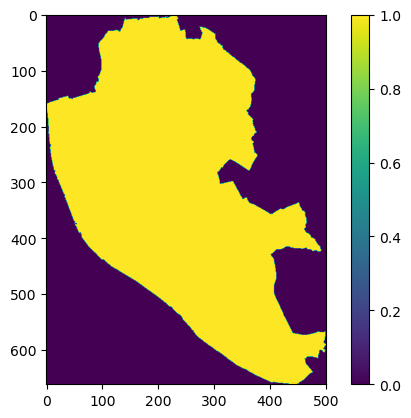

In [113]:
import rasterio.features

# Convert ward geometries to a list of tuples (geometry, value)
shapes = [(geom, 1) for geom in wards['geometry']]

# Rasterize the ward outlines
ward_mask = rasterio.features.rasterize(
    shapes=shapes,
    out_shape=landcover.shape,
    transform=affine_tfm
)

# Visualize the rasterized ward outlines
fig, ax = plt.subplots(1, 1)
im = ax.imshow(ward_mask)
fig.colorbar(im)


In [67]:
import numpy as np

# Open the Liverpool DEM raster
with rio.open('C:/EGM722/egm722/green_space_project/raster/LCM2015_Liverpool.tif') as dataset:
    dem = dataset.read(1)

In [68]:
# Create a mask for a specific ward (assuming the first ward in this case)
specific_ward = ward_mask == 1

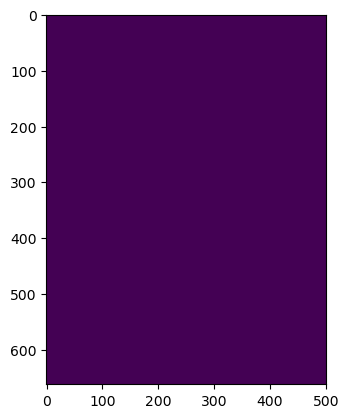

In [69]:
# Visualize the specific ward mask
fig, ax = plt.subplots(1, 1)
ax.imshow(specific_ward)

In [70]:
# Get the mean elevation of the specific ward
specific_ward_elevation = dem[specific_ward]
print('Mean elevation of the specific ward:', np.mean(specific_ward_elevation))

Mean elevation of the specific ward: nan


C:\Users\ellawallace\anaconda3\envs\egm722\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ellawallace\anaconda3\envs\egm722\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [114]:
import numpy as np
import rasterio as rio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterstats

# Define the extended list of landcover class names and corresponding raster values
names = ['Broadleaf woodland', 'Coniferous woodland', 'Arable and Horticulture', 'Improved grassland',
         'Semi-natural grassland', 'Mountain, heath, bog', 'Saltwater', 'Freshwater', 'Coastal',
         'Built-up areas and gardens', 'Neutral Grassland', 'Calcareous Grassland', 'Acid Grassland',
         'Heather', 'Heather grassland', 'Fen, Marsh and Swamp', 'Bog', 'Inland Rock', 'Urban',
         'Suburban', 'Supra-littoral Rock', 'Supra-littoral Sediment', 'Littoral Rock']
values = range(1, 24)  # Get numbers from 1-23, corresponding to the landcover values

# Create a dictionary of landcover value/name pairs
landcover_names = dict(zip(values, names))

# Open the Liverpool land cover raster and read the data
with rio.open('C:\\EGM722\\egm722\\green_space_project\\raster\\LCM2015_Liverpool.tif') as dataset:
    xmin, ymin, xmax, ymax = dataset.bounds
    crs = dataset.crs
    landcover = dataset.read(1)
    affine_tfm = dataset.transform

# Load the Liverpool wards shapefile
liverpool_wards = gpd.read_file('C:\\EGM722\\egm722\\green_space_project\\data_files\\Lwards.shp').to_crs(crs)

# Define a function to count unique elements of an array
def count_unique(array, names, nodata=0):
    count_dict = dict()
    for val in np.unique(array):
        if val == nodata:
            continue
        count_dict[names[val]] = np.count_nonzero(array == val)
    return count_dict

# Get counts of unique landcover classes in Liverpool
landcover_count = count_unique(landcover, landcover_names)

# Calculate the percentage area covered by each landcover class in Liverpool
total_pixels = np.count_nonzero(landcover != 0)  # Total non-zero pixels (excluding nodata)
percentage_area = {key: (value / total_pixels) * 100 for key, value in landcover_count.items()}

print(percentage_area)  # Show the results

# Use rasterstats to get zonal statistics for Liverpool wards
liverpool_stats = rasterstats.zonal_stats(liverpool_wards,  # Liverpool wards shapefile
                                          landcover,  # Liverpool landcover raster
                                          affine=affine_tfm,  # Geotransform of the raster
                                          categorical=True,  # Categorical data
                                          category_map=landcover_names,  # Mapping of categories
                                          nodata=0)  # Nodata value of the raster

print(liverpool_stats[0])  # Show zonal statistics for the first Liverpool ward


{'Broadleaf woodland': 5.233085789922782, 'Coniferous woodland': 0.1691496386348629, 'Arable and Horticulture': 5.664553049969999, 'Improved grassland': 7.7133441275526975, 'Semi-natural grassland': 3.7001860344510473, 'Acid Grassland': 0.14924968114840848, 'Heather': 1.0396220214135603, 'Fen, Marsh and Swamp': 0.8062497927087763, 'Bog': 0.24422675097012292, 'Inland Rock': 12.99889344175795, 'Urban': 0.20050714740139725, 'Suburban': 22.733590826722626, 'Supra-littoral Rock': 39.34734169734577}
{'Broadleaf woodland': 283, 'Improved grassland': 822, 'Fen, Marsh and Swamp': 89, 'Bog': 1, 'Inland Rock': 3, 'Urban': 5, 'Suburban': 372, 'Supra-littoral Rock': 971}


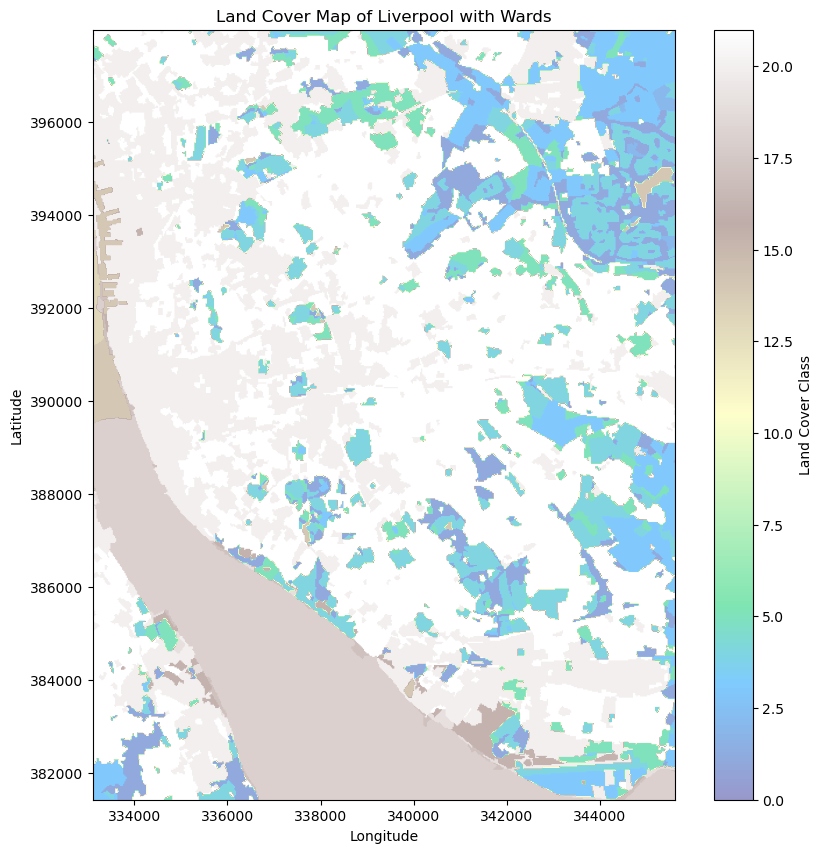

In [116]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the Liverpool wards shapefile
liverpool_wards = gpd.read_file('C:\\EGM722\\egm722\\green_space_project\\data_files\\Lwards.shp')

# Plot the Liverpool wards
fig, ax = plt.subplots(figsize=(10, 10))
liverpool_wards.plot(ax=ax, color='lightgrey', edgecolor='black')

# Overlay the land cover raster on top of the wards
im = ax.imshow(landcover, cmap='terrain', extent=(xmin, xmax, ymin, ymax), alpha=0.5)

# Add a colorbar for the land cover raster
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Land Cover Class')

# Set title and axis labels
ax.set_title('Land Cover Map of Liverpool with Wards')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


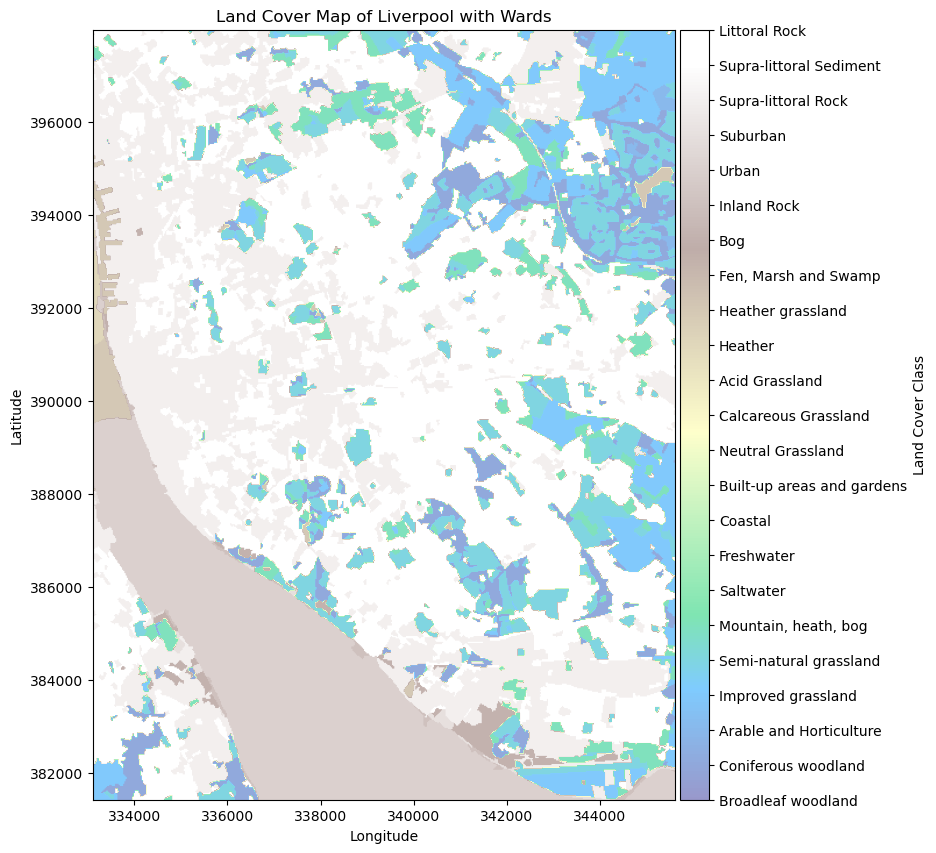

In [117]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the Liverpool wards shapefile
liverpool_wards = gpd.read_file('C:\\EGM722\\egm722\\green_space_project\\data_files\\Lwards.shp')

# Plot the Liverpool wards with boundaries
fig, ax = plt.subplots(figsize=(10, 10))
liverpool_wards.plot(ax=ax, color='none', edgecolor='black')

# Overlay the land cover raster on top of the wards
im = ax.imshow(landcover, cmap='terrain', extent=(xmin, xmax, ymin, ymax), alpha=0.5)

# Add a colorbar for the land cover raster
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Land Cover Class')

# Add legend for land cover classes
classes = ['Broadleaf woodland', 'Coniferous woodland', 'Arable and Horticulture', 'Improved grassland', 
           'Semi-natural grassland', 'Mountain, heath, bog', 'Saltwater', 'Freshwater', 'Coastal', 
           'Built-up areas and gardens', 'Neutral Grassland', 'Calcareous Grassland', 'Acid Grassland', 
           'Heather', 'Heather grassland', 'Fen, Marsh and Swamp', 'Bog', 'Inland Rock', 'Urban', 
           'Suburban', 'Supra-littoral Rock', 'Supra-littoral Sediment', 'Littoral Rock']
cbar.set_ticks(range(len(classes)))
cbar.set_ticklabels(classes)

# Set title and axis labels
ax.set_title('Land Cover Map of Liverpool with Wards')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


<>:5: SyntaxWarning: invalid escape sequence '\E'
<>:5: SyntaxWarning: invalid escape sequence '\E'
C:\Users\ellawallace\AppData\Local\Temp\ipykernel_12820\2819027179.py:5: SyntaxWarning: invalid escape sequence '\E'
  dem_raster_path = 'C:\EGM722\egm722\green_space_project\ASTGTM\ASTGTMV003_N53W003_dem.tif'


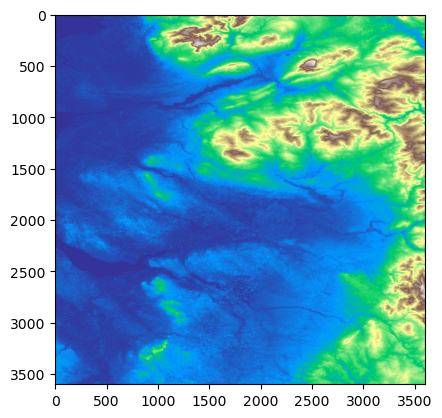

In [122]:
import rasterio
from rasterio.plot import show

# Path to your DEM file
dem_raster_path = 'C:\EGM722\egm722\green_space_project\ASTGTM\ASTGTMV003_N53W003_dem.tif'

# Open the DEM raster
with rasterio.open(dem_raster_path) as dem_src:
    # Read the data
    dem_data = dem_src.read(1)

    # Visualize the DEM
    show(dem_data, cmap='terrain')


In [127]:
with rio.open('C:\EGM722\egm722\green_space_project\ASTGTM\ASTGTMV003_N53W003_dem.tif') as dataset:
    dem = dataset.read(1)

<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\ellawallace\AppData\Local\Temp\ipykernel_12820\1821485335.py:1: SyntaxWarning: invalid escape sequence '\E'
  with rio.open('C:\EGM722\egm722\green_space_project\ASTGTM\ASTGTMV003_N53W003_dem.tif') as dataset:


In [131]:
import rasterio.features # we have imported rasterio as rio, so this will be rio.features (and rasterio.features)
import rasterio as rio
from rasterio import features
import numpy as np

In [159]:
import geopandas as gpd

# Load the shapefile
wards = gpd.read_file("C:/EGM722/egm722/green_space_project/data_files/Lwards.shp")

# Display the first 10 rows of the attribute table
print(wards.head(10))


   WARDNUMBER               WARDNAME DISTRICTNA  COUNTYNAME  NOCLLRS  \
0         1.0               Aigburth  Liverpool  Merseyside      1.0   
1        10.0              Childwall  Liverpool  Merseyside      2.0   
2        11.0                 Church  Liverpool  Merseyside      1.0   
3        12.0      City Centre North  Liverpool  Merseyside      2.0   
4        13.0      City Centre South  Liverpool  Merseyside      3.0   
5        14.0          Clubmoor East  Liverpool  Merseyside      1.0   
6        15.0          Clubmoor West  Liverpool  Merseyside      1.0   
7        16.0                 County  Liverpool  Merseyside      2.0   
8        17.0               Croxteth  Liverpool  Merseyside      1.0   
9        18.0  Croxteth Country Park  Liverpool  Merseyside      1.0   

          WD23CD                                           geometry  
0  E05015277\r\n  POLYGON ((-2.92245 53.35724, -2.92247 53.35725...  
1  E05015286\r\n  POLYGON ((-2.88995 53.40698, -2.88971 53.40701...

In [160]:
# Create a list of geometry, value pairs for wards
wards_shapes = list(zip(wards['geometry'], wards['WARDNUMBER']))
wards_mask = rio.features.rasterize(shapes=shapes, # the list of geometry/value pairs
                                     fill=0, # the value to use for cells not covered by any geometry
                                     out_shape=landcover.shape, # the shape of the new raster
                                     transform=affine_tfm) # the geotransform of the new raster

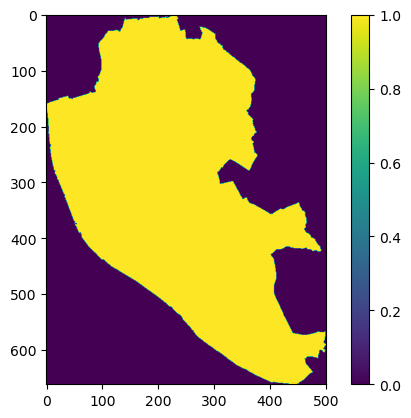

In [161]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(wards_mask) # visualize the rasterized output
fig.colorbar(im) # show a colorbar

In [166]:
with rio.open('C:/EGM722/egm722/green_space_project/ASTGTM/ASTGTMV003_N53W003_dem.tif') as dataset:
    dem = dataset.read(1)

In [167]:
Aigburth = wards_mask == 1

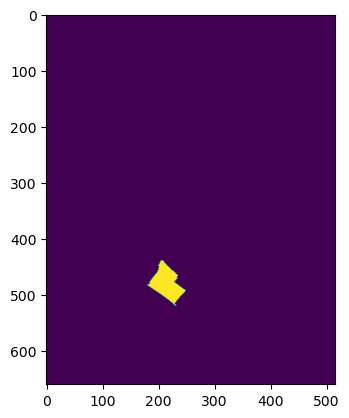

In [168]:
Aigburth = wards_mask == 1

fig, ax = plt.subplots(1, 1)
ax.imshow(Aigburth) # visualize the rasterized output

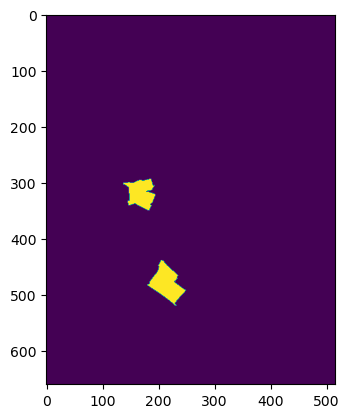

In [171]:
aigburth_and_allerton = np.logical_or(wards_mask == 20, wards_mask == 1)

fig, ax = plt.subplots(1, 1)
ax.imshow(aigburth_and_allerton)

In [139]:
# Rasterize the wards
wards_raster = features.rasterize(shapes=wards_shapes,
                                  fill=0,
                                  out_shape=landcover.shape,
                                  transform=affine_tfm,
                                  dtype=np.uint8)

In [172]:
aa_elevation = dem[aigburth_and_allerton] # index the array using the antrim_and_down mask
print('Mean elevation: {:.2f} m'.format(aa_elevation.mean()))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3601 but corresponding boolean dimension is 660

In [173]:
broad_els = dem[landcover == 1] # get all dem values where landcover = 1
conif_els = dem[landcover == 2] # get all dem values where landcover = 2

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3601 but corresponding boolean dimension is 660

In [174]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the DEM data
with rio.open('path_to_your_DEM_file.tif') as src:
    dem = src.read(1)

# Assuming you have a landcover raster with values where 1 corresponds to Broadleaf Woodland and 2 corresponds to Conifer Woodland
# You should replace 'path_to_your_landcover_raster.tif' with the actual path to your landcover raster
with rio.open('path_to_your_landcover_raster.tif') as src:
    landcover = src.read(1)

# Define elevation bins
el_bins = np.arange(0, 600, 5)  # Create an array of values ranging from 0 to 600, spaced by 5 meters

# Extract elevation data for Broadleaf Woodland and Conifer Woodland
broad_els = dem[landcover == 1]  # Get all DEM values where landcover = 1 (Broadleaf Woodland)
conif_els = dem[landcover == 2]  # Get all DEM values where landcover = 2 (Conifer Woodland)

# Bin the elevations using the elevation bins
broad_count, _ = np.histogram(broad_els, el_bins)  # Bin the Broadleaf Woodland elevations
conif_count, _ = np.histogram(conif_els, el_bins)  # Bin the Conifer Woodland elevations

# Convert the pixel counts to area by multiplying by the pixel size in x, y
pixel_area = 100 * 100  # Assuming each pixel represents 100m x 100m area
broad_area = broad_count * pixel_area  # Broadleaf Woodland area
conif_area = conif_count * pixel_area  # Conifer Woodland area

# Plot the area-elevation distribution for each land cover type
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
_ = ax.bar(el_bins[:-1], broad_area / 1e6, align='edge', width=5, alpha=0.8, label='Broadleaf Woodland')
_ = ax.bar(el_bins[:-1], conif_area / 1e6, align='edge', width=5, alpha=0.8, label='Conifer Woodland')
ax.set_xlim(0, 550)
ax.set_ylim(0, 30)
ax.set_xlabel('Elevation (m)')
ax.set_ylabel('Area (km$^2$)')
ax.legend()

# Calculate descriptive statistics for each land cover type
broad_stats = {
    'mean': np.mean(broad_els),
    'median': np.median(broad_els),
    'std. dev': np.std(broad_els),
    'max': np.max(broad_els),
    'min': np.min(broad_els),
    'range': np.max(broad_els) - np.min(broad_els)
}

conif_stats = {
    'mean': npimport rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the DEM data
with rio.open('path_to_your_DEM_file.tif') as src:
    dem = src.read(1)

# Assuming you have a landcover raster with values where 1 corresponds to Broadleaf Woodland and 2 corresponds to Conifer Woodland
# You should replace 'path_to_your_landcover_raster.tif' with the actual path to your landcover raster
with rio.open('path_to_your_landcover_raster.tif') as src:
    landcover = src.read(1)

# Define elevation bins
el_bins = np.arange(0, 600, 5)  # Create an array of values ranging from 0 to 600, spaced by 5 meters

# Extract elevation data for Broadleaf Woodland and Conifer Woodland
broad_els = dem[landcover == 1]  # Get all DEM values where landcover = 1 (Broadleaf Woodland)
conif_els = dem[landcover == 2]  # Get all DEM values where landcover = 2 (Conifer Woodland)

# Bin the elevations using the elevation bins
broad_count, _ = np.histogram(broad_els, el_bins)  # Bin the Broadleaf Woodland elevations
conif_count, _ = np.histogram(conif_els, el_bins)  # Bin the Conifer Woodland elevations

# Convert the pixel counts to area by multiplying by the pixel size in x, y
pixel_area = 100 * 100  # Assuming each pixel represents 100m x 100m area
broad_area = broad_count * pixel_area  # Broadleaf Woodland area
conif_area = conif_count * pixel_area  # Conifer Woodland area

# Plot the area-elevation distribution for each land cover type
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
_ = ax.bar(el_bins[:-1], broad_area / 1e6, align='edge', width=5, alpha=0.8, label='Broadleaf Woodland')
_ = ax.bar(el_bins[:-1], conif_area / 1e6, align='edge', width=5, alpha=0.8, label='Conifer Woodland')
ax.set_xlim(0, 550)
ax.set_ylim(0, 30)
ax.set_xlabel('Elevation (m)')
ax.set_ylabel('Area (km$^2$)')
ax.legend()

# Calculate descriptive statistics for each land cover type
broad_stats = {
    'mean': np.mean(broad_els),
    'median': np.median(broad_els),
    'std. dev': np.std(broad_els),
    'max': np.max(broad_els),
    'min': np.min(broad_els),
    'range': np.max(broad_els) - np.min(broad_els)
}

conif_stats = {
    'mean': np.mean(conif_els),
    'median': np.median(conif_els),
    'std. dev': np.std(conif_els),
    'max': np.max(conif_els),
    'min': np.min(conif_els),
    'range': np.max(conif_els) - np.min(conif_els)
}

# Create a DataFrame of descriptive statistics
landcover_els = pd.DataFrame(columns=['name', 'mean', 'median', 'std. dev', 'max', 'min', 'range'])
landcover_els['name'] = ['Broadleaf Woodland', 'Conifer Woodland']
landcover_els = landcover_els.append(pd.DataFrame([broad_stats, conif_stats]), ignore_index=True)

print(landcover_els)
.mean(conif_els),
    'median': np.median(conif_els),
    'std. dev': np.std(conif_els),
    'max': np.max(conif_els),
    'min': np.min(conif_els),
    'range': np.max(conif_els) - np.min(conif_els)
}

# Create a DataFrame of descriptive statistics
landcover_els = pd.DataFrame(columns=['name', 'mean', 'median', 'std. dev', 'max', 'min', 'range'])
landcover_els['name'] = ['Broadleaf Woodland', 'Conifer Woodland']
landcover_els = landcover_els.append(pd.DataFrame([broad_stats, conif_stats]), ignore_index=True)

print(landcover_els)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1487660608.py, line 52)

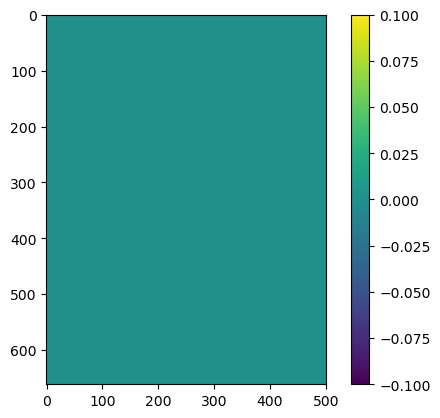

In [140]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(wards_raster) # visualize the rasterized output
fig.colorbar(im) # show a colorbar

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]


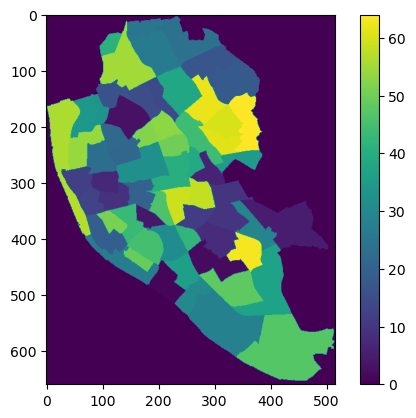

In [165]:
import geopandas as gpd
import rasterio as rio
from rasterio.features import rasterize
import numpy as np

# Load the landcover raster
with rio.open("C:/EGM722/egm722/green_space_project/raster/LCM2015_LP.tif") as src:
    landcover = src.read(1)
    affine_tfm = src.transform

# Load the wards shapefile
wards = gpd.read_file("C:/EGM722/egm722/green_space_project/data_files/Lwards.shp")

# Rasterize the wards
wards_shapes = list(zip(wards['geometry'], wards['WARDNUMBER']))
wards_mask = rasterize(shapes=wards_shapes,
                       fill=0,
                       out_shape=landcover.shape,
                       transform=affine_tfm,
                       dtype=np.uint8)

# Print unique values in the rasterized array
print(np.unique(wards_mask))

# Visualize the rasterized output
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
im = ax.imshow(wards_mask, cmap='viridis')  # Use a colormap that distinguishes different values
fig.colorbar(im)
plt.show()


In [164]:
import rasterio as rio
import geopandas as gpd

# Load the landcover raster
with rio.open("C:/EGM722/egm722/green_space_project/raster/LCM2015_LP.tif") as src:
    landcover_crs = src.crs

# Load the wards shapefile
wards = gpd.read_file("C:/EGM722/egm722/green_space_project/data_files/Lwards.shp")
wards_crs = wards.crs

# Print CRS information
print("Landcover CRS:", landcover_crs)
print("Wards CRS:", wards_crs)


Landcover CRS: EPSG:4326
Wards CRS: EPSG:4326
